# Traffic Data Analysis

This is a preliminary analysis of traffic crash data made available at 
https://opendata-nzta.opendata.arcgis.com/datasets/crash-analysis-system-cas-data-1/explore?location=-9.510847%2C0.000000%2C2.92

Note that this dataset is not static, therefore its contents may have changed since the time it was downloaded for the purpose of this analysis.

The goal is to
- Characterize the dataset.
- Discern basic trends concerning crash metrics contained in the dataset.


In [2]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
import os

In [3]:
# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# Define functions
def get_dataset_stats(df, exclude=["excluded_col_1","excluded_col_2"], round_digits=3):
    """
    PARAMETERS:
        df - A dataframe 
    
    RETURNS: a dataframe
    """


    include_columns = list(df.columns)
    for element in exclude:
        if element in include_columns:
            include_columns.remove(element)
    
    
    types_df = pd.DataFrame(df[include_columns].dtypes).rename({0:"dtype"}, axis=1)
    obj_list = df[include_columns].select_dtypes(include=['object']).columns.to_list()
    # local function to determine new datatypes for object columns:
    def get_obj_type(df, var):
        type = ""
        if df[var].isnull().all():
            type = 'none'
        else:
            try:
                df[var].astype("datetime64[ns]")
                type = 'datetime64[ns]'
            except:
                try:
                    df[var].astype("int64")
                    type = 'int64'
                except:
                    try:
                        df[var].astype("float64")
                        type = 'float64'  
                    except:
                        try:
                            df[var].astype("str")
                            type = 'str'
                        except:
                            type = 'str'
                            pass
        return type    
    
    for col in obj_list:
        new_type = get_obj_type(df, col)
        print("{} new type is {}".format(col, new_type))
        types_df["dtype"][col] = new_type
    
    
    dg = pd.DataFrame(np.nan, index=include_columns, 
                      columns=["type","excluded","non_null_count","nullcnt","%nulls","min",
                               "pcntl25","median","mean","pcntl75","max",
                               "stddev","str-maxlen","str-meanlen","str-medianlen","str-minlen","ndistinct"])
    
    try:
        for varname in include_columns:
            if str(types_df["dtype"][varname]) in ["datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]"]:
                df[varname] = df[varname].dt.tz_localize(None)
                types_df["dtype"][varname] = "datetime64[ns]"
                
            dg.type.loc[varname] = types_df.loc[varname, "dtype"]
            if dg.type.loc[varname] == 'float64':
                df[varname] = df[varname].astype('float')
            elif dg.type.loc[varname] == 'int64':
                df[varname] = df[varname].astype('int')
            if varname in exclude:
                dg.loc[varname,"excluded"] = 'Yes'
            else:
                dg.loc[varname,"excluded"] = 'No'
            # print("Var: {}  Type: {}".format(varname, dg.type.loc[varname]))
            dg.loc[varname,"ndistinct"] = df[varname].nunique()

            if types_df["dtype"][varname] in ["float64","int64","int32","datetime64[ns]","str","none"]:
                dg.loc[varname, "nullcnt"] = df[varname].isna().sum().astype(int)
                totalcnt = df[varname].count().astype(int) + dg.loc[varname, "nullcnt"]
                dg.loc[varname,"non_null_count"] = totalcnt - dg.loc[varname, "nullcnt"]
                dg.loc[varname,"%nulls"] = (100.0 * dg.loc[varname,"nullcnt"] / totalcnt).round(decimals=2)
            if types_df["dtype"][varname] in ["datetime64[ns]"]:
                dg.loc[varname,"min"] = df[varname].dropna().min()
                dg.loc[varname,"max"] = df[varname].dropna().max()
                dg.loc[varname,"mean"] = df[varname].dropna().mean()
            elif types_df["dtype"][varname] in ["float64","int64","int32"]:
                dg.loc[varname,"min"] = round(df[varname].dropna().min(), round_digits)
                dg.loc[varname,"max"] = round(df[varname].dropna().max(), round_digits)
                dg.loc[varname,"mean"] = round(df[varname].dropna().mean(), round_digits)                
            if types_df["dtype"][varname] in ["float64","int64","int32"]:
                dg.loc[varname,"pcntl25"] = round(df[varname].dropna().quantile(0.25), round_digits)
                dg.loc[varname,"median"] = round(df[varname].dropna().quantile(0.5), round_digits) 
                dg.loc[varname,"pcntl75"] = round(df[varname].dropna().quantile(0.75), round_digits)
                dg.loc[varname,"stddev"] = round(df[varname].dropna().std(), round_digits)
            if types_df["dtype"][varname] in ["str"] and varname not in exclude:
                dg.loc[varname,"str-maxlen"] = df[varname].str.len().max()
                dg.loc[varname,"str-meanlen"] = df[varname].str.len().mean()
                dg.loc[varname,"str-medianlen"] = df[varname].str.len().median()
                dg.loc[varname,"str-minlen"] = df[varname].str.len().min()
                           
    except:
        print("Failed iteration on variable: {}".format(varname))
    
    return dg

In [5]:
# Define working directories
data_dir = "../data"
output_dir = "../outputs"
os.chdir(data_dir)
os.getcwd()

'D:\\Projects\\Traffic_Data_Study\\Traffic_Data_Study\\data'

In [6]:
## Load data
df = pd.read_csv("Crash_Analysis_System_(CAS)_data.csv")

In [7]:
df.head(6)

X          Y  OBJECTID  advisorySpeed  areaUnitID  bicycle  bridge  \
0  1772561.0  5896382.0         1            NaN    525420.0      0.0     NaN   
1  1836757.0  5859311.0         3            NaN    534300.0      0.0     NaN   
2  1762088.0  5912507.0         4            NaN    519500.0      0.0     NaN   
3  1753522.0  5911939.0         6            NaN    518902.0      0.0     NaN   
4  1761364.0  5914259.0         7            NaN    520202.0      0.0     NaN   
5  1803464.0  5815043.0         9            NaN    530500.0      0.0     NaN   

   bus  carStationWagon  cliffBank crashDirectionDescription  \
0  0.0              1.0        NaN                      Null   
1  0.0              2.0        NaN                      Null   
2  0.0              1.0        NaN                      West   
3  0.0              2.0        NaN                      Null   
4  0.0              2.0        NaN                      Null   
5  0.0              3.0        NaN                     North   

  crashFinancialYear crashLocation1       crashLocation2  crashRoadSideRoad  \
0          2007/2008        EAST ST            ELLIOT ST                NaN   
1          2002/2003           SH 2                SH 26                NaN   
2          2009/2010      CHURCH ST  HUGO JOHNSTON DRIVE                NaN   
3          2017/2018     THE AVENUE            ACCESSWAY                NaN   
4          2017/2018    PENROSE INT        GT SOUTH LINK                NaN   
5          2009/2010  KNIGHTON ROAD          HELENA ROAD                NaN   

      crashSeverity crashSHDescription  crashYear  debris  \
0  Non-Injury Crash                 No       2007     NaN   
1  Non-Injury Crash                Yes       2003     NaN   
2  Non-Injury Crash                 No       2010     NaN   
3       Minor Crash                 No       2017     NaN   
4  Non-Injury Crash                 No       2018     NaN   
5       Minor Crash                 No       2010     NaN   

  directionRoleDescription  ditch  fatalCount  fence   flatHill  guardRail  \
0                    North    NaN         0.0    NaN       Flat        NaN   
1                    North    NaN         0.0    NaN       Flat        NaN   
2                     East    NaN         0.0    NaN       Flat        NaN   
3                    North    NaN         0.0    NaN  Hill Road        NaN   
4                    North    NaN         0.0    NaN       Flat        NaN   
5                    South    NaN         0.0    NaN       Flat        NaN   

           holiday  houseOrBuilding  intersection  kerb       light  \
0              NaN              NaN           NaN   NaN        Dark   
1              NaN              NaN           NaN   NaN        Dark   
2  Queens Birthday              NaN           NaN   NaN  Bright sun   
3              NaN              NaN           NaN   NaN    Overcast   
4              NaN              NaN           NaN   NaN    Overcast   
5              NaN              NaN           NaN   NaN    Overcast   

   meshblockId  minorInjuryCount  moped  motorcycle  NumberOfLanes  \
0     791600.0               0.0    0.0         0.0            2.0   
1    1073700.0               0.0    0.0         0.0            2.0   
2     622400.0               0.0    0.0         0.0            2.0   
3     587500.0               1.0    0.0         0.0            2.0   
4     612300.0               0.0    0.0         0.0            2.0   
5     891500.0               1.0    0.0         0.0            2.0   

   objectThrownOrDropped  otherObject  otherVehicleType  overBank  \
0                    NaN          NaN               0.0       NaN   
1                    NaN          NaN               0.0       NaN   
2                    NaN          NaN               0.0       NaN   
3                    NaN          NaN               0.0       NaN   
4                    NaN          NaN               0.0       NaN   
5                    NaN          NaN               0.0       

In [8]:
# Obtain basic information: field names, datatypes, non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776878 entries, 0 to 776877
Data columns (total 72 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   X                          776878 non-null  float64
 1   Y                          776878 non-null  float64
 2   OBJECTID                   776878 non-null  int64  
 3   advisorySpeed              29289 non-null   float64
 4   areaUnitID                 776762 non-null  float64
 5   bicycle                    776873 non-null  float64
 6   bridge                     310482 non-null  float64
 7   bus                        776873 non-null  float64
 8   carStationWagon            776873 non-null  float64
 9   cliffBank                  310482 non-null  float64
 10  crashDirectionDescription  776878 non-null  object 
 11  crashFinancialYear         776878 non-null  object 
 12  crashLocation1             776878 non-null  object 
 13  crashLocation2             77

In [9]:
# Produce basic statistical report. Determine viable atomic types for those columns of 'object' Dtype.
df_stats = get_dataset_stats(df)


crashDirectionDescription new type is str
crashFinancialYear new type is str
crashLocation1 new type is str
crashLocation2 new type is str
crashSeverity new type is str
crashSHDescription new type is str
directionRoleDescription new type is str
flatHill new type is str
holiday new type is str
light new type is str
region new type is str
roadCharacter new type is str
roadLane new type is str
roadSurface new type is str
streetLight new type is str
tlaName new type is str
trafficControl new type is str
urban new type is str
weatherA new type is str
weatherB new type is str


D:\Users\darryl.boswell\.conda\envs\kowhai\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
# Display computed column metrics for dataframe.
df_stats

type excluded  non_null_count   nullcnt  %nulls  \
X                          float64       No        776878.0       0.0    0.00   
Y                          float64       No        776878.0       0.0    0.00   
OBJECTID                     int64       No        776878.0       0.0    0.00   
advisorySpeed              float64       No         29289.0  747589.0   96.23   
areaUnitID                 float64       No        776762.0     116.0    0.01   
bicycle                    float64       No        776873.0       5.0    0.00   
bridge                     float64       No        310482.0  466396.0   60.03   
bus                        float64       No        776873.0       5.0    0.00   
carStationWagon            float64       No        776873.0       5.0    0.00   
cliffBank                  float64       No        310482.0  466396.0   60.03   
crashDirectionDescription      str       No        776878.0       0.0    0.00   
crashFinancialYear             str       No        776878.0       0.0    0.00   
crashLocation1                 str       No        776878.0       0.0    0.00   
crashLocation2                 str       No        775957.0     921.0    0.12   
crashRoadSideRoad          float64       No             0.0  776878.0  100.00   
crashSeverity                  str       No        776878.0       0.0    0.00   
crashSHDescription             str       No        776877.0       1.0    0.00   
crashYear                    int64       No        776878.0       0.0    0.00   
debris                     float64       No        310482.0  466396.0   60.03   
directionRoleDescription       str       No        776799.0      79.0    0.01   
ditch                      float64       No        310482.0  466396.0   60.03   
fatalCount                 float64       No        776742.0     136.0    0.02   
fence                      float64       No        310482.0  466396.0   60.03   
flatHill                       str       No        776878.0       0.0    0.00   
guardRail                  float64       No        310482.0  466396.0   60.03   
holiday                        str       No         42358.0  734520.0   94.55   
houseOrBuilding            float64       No        310482.0  466396.0   60.03   
intersection               float64       No             0.0  776878.0  100.00   
kerb                       float64       No        310482.0  466396.0   60.03   
light                          str       No        776878.0       0.0    0.00   
meshblockId                float64       No        776762.0     116.0    0.01   
minorInjuryCount           float64       No        776742.0     136.0    0.02   
moped                      float64       No        776873.0       5.0    0.00   
motorcycle                 float64       No        776873.0       5.0    0.00   
NumberOfLanes              float64       No        775343.0    1535.0    0.20   
objectThrownOrDropped      float64       No        310482.0  466396.0   60.03   
otherObject                float64       No        310482.0  466396.0   60.03   
otherVehicleType           float64       No        776873.0       5.0    0.00   
overBank                   float64       No        310482.0  466396.0   60.03   
parkedVehicle              float64       No        310482.0  466396.0   60.03   
pedestrian                 float64       No         24770.0  752108.0   96.81   
phoneBoxEtc                float64       No        310482.0  466396.0   60.03   
postOrPole                 float64       No        310482.0  466396.0   60.03   
region                         str       No        773852.0    3026.0    0.39   
roadCharacter                  str       No        776878.0       0.0    0.00   
roadLane                       str       No        776878.0       0.0    0.00   
roadSurface                    str       No        776878.0       0.0    0.00   
roadworks                  float64       No        310482.0  466396.0   60.03   
schoolBus                  float64       No        776873.0  

In [11]:
# Determine measures that have no non-null values. These could be dropped, since they provide no information, 
# however we will retain them to keep the original frame structure.
df_stats[df_stats["non_null_count"] == 0]

type excluded  non_null_count   nullcnt  %nulls  min  \
crashRoadSideRoad  float64       No             0.0  776878.0   100.0  NaN   
intersection       float64       No             0.0  776878.0   100.0  NaN   

                   pcntl25  median  mean  pcntl75  max  stddev  str-maxlen  \
crashRoadSideRoad      NaN     NaN   NaN      NaN  NaN     NaN         NaN   
intersection           NaN     NaN   NaN      NaN  NaN     NaN         NaN   

                   str-meanlen  str-medianlen  str-minlen  ndistinct  
crashRoadSideRoad          NaN            NaN         NaN        0.0  
intersection               NaN            NaN         NaN        0.0

### Find all values for low-cardinality str columns.

(a) Let's check whether the actual value ranges align with those declared in the field descriptions.
    Of special interest will be nulls, NaNs or obvious proxies for these.
    
(b) Some of these features may be candidates for one-hot-encoding if ML is applied on this dataset.

(c) We have arbitrarily set the "low cardinality" threshold to 60, though in practice most string columns of interest have
    fewer distinct values, as can be seen from the column statistics.

In [24]:
distinct_vals = pd.DataFrame(data=None, columns=['Variable', 'Value','Count'])
cardinality_thrsld = 60
for col in df_stats[df_stats.type == 'str'][df_stats.ndistinct < cardinality_thrsld].index.values.tolist():
    for val in df[col].unique():
        if pd.isna(val):
            count = len(df[df[col].isnull()]) # Count the occurrence of NaN values if applicable within this column
        else:
            count = len(df[df[col] == val]) # Count the occurrence of this value within this column
        # Append to dataframe
        distinct_vals.loc[len(distinct_vals)] = [col, val, count]

D:\Users\darryl.boswell\.conda\envs\kowhai\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


This can aid in decisions about imputing or dropping missing data, where relevant. For example, region shows 3026 cases with value NaN. This may imply either absence of information about the region, or it may imply locations that legitimately lie outside any region. In some contexts it may be valid to treat these as a category; in others to drop these records.
Similar considerations apply to other cases where NaN appears as a value for a categorical variable.

In [25]:
distinct_vals

Variable                                          Value  \
0    crashDirectionDescription                                           Null   
1    crashDirectionDescription                                           West   
2    crashDirectionDescription                                          North   
3    crashDirectionDescription                                          South   
4    crashDirectionDescription                                           East   
5           crashFinancialYear                                      2007/2008   
6           crashFinancialYear                                      2002/2003   
7           crashFinancialYear                                      2009/2010   
8           crashFinancialYear                                      2017/2018   
9           crashFinancialYear                                      2013/2014   
10          crashFinancialYear                                      2010/2011   
11          crashFinancialYear                                      2015/2016   
12          crashFinancialYear                                      2016/2017   
13          crashFinancialYear                                      2001/2002   
14          crashFinancialYear                                      2006/2007   
15          crashFinancialYear                                      2020/2021   
16          crashFinancialYear                                      2008/2009   
17          crashFinancialYear                                      2004/2005   
18          crashFinancialYear                                      2011/2012   
19          crashFinancialYear                                      2014/2015   
20          crashFinancialYear                                      2000/2001   
21          crashFinancialYear                                      1999/2000   
22          crashFinancialYear                                      2003/2004   
23          crashFinancialYear                                      2005/2006   
24          crashFinancialYear                                      2012/2013   
25          crashFinancialYear                                      2018/2019   
26          crashFinancialYear                                      2019/2020   
27          crashFinancialYear                                      2021/2022   
28               crashSeverity                               Non-Injury Crash   
29               crashSeverity                                    Minor Crash   
30               crashSeverity                                    Fatal Crash   
31               crashSeverity                                  Serious Crash   
32          crashSHDescription                                             No   
33          crashSHDescription                                            Yes   
34          crashSHDescription                                        Unknown   
35    directionRoleDescription                                          North   
36    directionRoleDescription                                           East   
37    directionRoleDescription                                          South   
38    directionRoleDescription                                           West   
39    directionRoleDescription                                           Null   
40                    flatHill                                           Flat   
41                    flatHill                                      Hill Road   
42                    flatHill                                           Null   
43                     holiday                                            NaN   
44                     holiday                                Queens Birthday   
45                     holiday                             Christmas New Year   
46                     holiday                                         Easter   
47                     holiday                                 Labour Weekend   
48                       light                       

In [14]:
# For the above cases, 'Null' and 'Nil' are probably equivalent. For 'region', NaN might be better recoded 
# to a specific value such as 'Other', since 'region' is probably a variable we want to use, and there seems no obvious 
# reason at this stage to discard the data.
df['region'].fillna('Other',inplace=True)

In [15]:
# Did this work?
len(df[df['region'].isnull()]) # 0 is good.

0

In [16]:
# The one record having NaN value in 'crashSHDescription' is well formed. The value is probably equivalent to 'Unknown'.
# This is an ASSUMPTION.
df[df['crashSHDescription'].isnull()]

X             Y  OBJECTID  advisorySpeed  areaUnitID  \
560970  1.836611e+06  5.866924e+06    920329            NaN         NaN   

        bicycle  bridge  bus  carStationWagon  cliffBank  \
560970      0.0     0.0  0.0              1.0        0.0   

       crashDirectionDescription crashFinancialYear crashLocation1  \
560970                     South          2019/2020       026-0070   

       crashLocation2  crashRoadSideRoad  crashSeverity crashSHDescription  \
560970  ROBINSON ROAD                NaN  Serious Crash                NaN   

        crashYear  debris directionRoleDescription  ditch  fatalCount  fence  \
560970       2019     0.0                    South    1.0         0.0    0.0   

       flatHill  guardRail holiday  houseOrBuilding  intersection  kerb light  \
560970     Flat        0.0     NaN              0.0           NaN   0.0  Dark   

        meshblockId  minorInjuryCount  moped  motorcycle  NumberOfLanes  \
560970          NaN               0.0    0.0         0.0            2.0   

        objectThrownOrDropped  otherObject  otherVehicleType  overBank  \
560970                    0.0          0.0               0.0       1.0   

        parkedVehicle  pedestrian  phoneBoxEtc  postOrPole region  \
560970            0.0         NaN          0.0         0.0  Other   

       roadCharacter roadLane roadSurface  roadworks  schoolBus  \
560970           Nil    2-way      Sealed        0.0        0.0   

        seriousInjuryCount  slipOrFlood  speedLimit  strayAnimal streetLight  \
560970                 1.0          0.0       100.0          0.0        None   

        suv  taxi  temporarySpeedLimit  tlaId tlaName trafficControl  \
560970  0.0   0.0                  NaN    NaN     NaN        Unknown   

        trafficIsland  trafficSign  train  tree  truck  unknownVehicleType  \
560970            0.0          0.0    0.0   1.0    0.0                 0.0   

       urban  vanOrUtility  vehicle  waterRiver weatherA weatherB  
560970  Open           0.0      0.0         0.0     Fine     Null

In [17]:
df['crashSHDescription'].fillna('Unknown',inplace=True)

In [18]:
len(df[df['crashSHDescription'].isnull()]) # 0 is good.

0

In [22]:
# Similarly for 'directionRoleDescription', NaN is probably equivalent to 'Null'.
df['directionRoleDescription'].fillna('Null',inplace=True)

In [23]:
len(df[df['directionRoleDescription'].isnull()]) # 0 is good.

0

## General observations of dataset

1. The granularity of date / time observations is 1 year (calendar or financial).
   This would preclude detailed time series analysis of (for example) seasonal, weekly, or diurnal effects.
   
2. Depending on the specific subject of analysis, it may be expedient to relate these data to external datasets. Explicit      joins to other geodata may be possible via the coordinates or via the 'crashLocation1' and 'crashLocation2' fields.

3. The field descriptions at https://opendata-nzta.opendata.arcgis.com/pages/cas-data-field-descriptions do not list          'intersection' or 'crashSideRoad'. However, although these columns appear in the crash dataset, they contain no non-null    values.

   Although listed in the field descriptions, 'junctionType' and 'intersectionMidblock' does not appear in the dataset.        
   The 'northing' and 'easting' variables listed in the field descriptions do not appear in the downloaded CSV dataset.
   
   Could it be that these are excluded from the CSV download, but included in geoJson or KML versions?



### Let's plot crash severity trends by region.

In [33]:
crashes_by_region = df['region'].value_counts()
crashes_by_region

Auckland Region              271695
Waikato Region                82373
Canterbury Region             77790
Wellington Region             75434
Bay of Plenty Region          44247
Manawatū-Whanganui Region     43161
Otago Region                  42366
Northland Region              31143
Hawke's Bay Region            30379
Southland Region              19221
Taranaki Region               17438
Gisborne Region                9160
Marlborough Region             7825
Nelson Region                  7670
Tasman Region                  7102
West Coast Region              6848
Other                          3026
Name: region, dtype: int64

<AxesSubplot:>

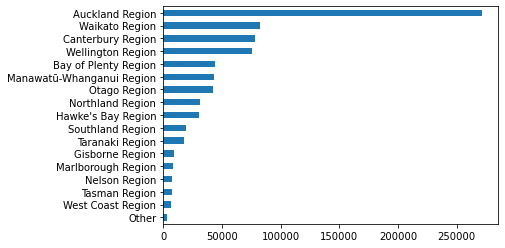

In [38]:
crashes_by_region[::-1].plot(kind = 'barh')

It might be instructive to analyze down to Area Units. (AUs) The AU names could be substituted by 
joining to an appropriate Department of Statistics dataset containing the names. However, these values have not remained static over the lifetime of this crash dataset, and have been replaced (since 2018) by SA2s, which are not necessarily geographically consistent with AUs, and do not have the same identifier codes. This entails complications that are best avoided for the present exercise.

In [40]:
crashes_by_au = df['areaUnitID'].value_counts()
crashes_by_au

520500.0    6409
514102.0    5505
529700.0    4788
524604.0    4432
573101.0    4297
514103.0    4043
591500.0    3768
507900.0    3456
573000.0    3042
509800.0    2861
562800.0    2845
515202.0    2765
524200.0    2714
521901.0    2687
513301.0    2649
520202.0    2602
544600.0    2459
603100.0    2441
548200.0    2369
514101.0    2329
515700.0    2319
509702.0    2300
569100.0    2297
594600.0    2268
572900.0    2261
524602.0    2240
511303.0    2199
536821.0    2089
514200.0    2071
528900.0    2036
551800.0    2026
503100.0    2009
540410.0    1989
508420.0    1964
538201.0    1960
514801.0    1933
533603.0    1860
516001.0    1841
611210.0    1802
510800.0    1751
516003.0    1745
581230.0    1723
516002.0    1685
608302.0    1682
591700.0    1681
528403.0    1668
514000.0    1664
508320.0    1656
524603.0    1650
538102.0    1648
510700.0    1647
519820.0    1629
546901.0    1621
508701.0    1615
541720.0    1603
508807.0    1596
566000.0    1591
514401.0    1587
511100.0    15

In [ ]:
plt.plot(df['crashYear'], df['minorInjuryCount'], 'ro', linestyle="None")
plt.xlabel("Year")
plt.ylabel("Count of Minor Injuries")
plt.title("XXX")
fig1 = plt.gcf()
plt.show()  # show first chart
plt.draw()
fig1.savefig("../outputs/frst_pic.png", dpi=100)

In [ ]:
import seaborn as sns

## Univariate histograms

In [ ]:
sns.histplot(data=df, x="crashYear", binwidth=1, color="green", hue="region", multiple="stack")

In [ ]:
sns.histplot(data=df, x="crashYear", binwidth=1, color="green", hue="region", element="step")

In [ ]:
sns.histplot(data=df, x="crashYear", binwidth=1, color="green", hue="region", element="poly")

## Bivariate histograms

In [ ]:
sns.histplot(df, x="crashYear", y="crashSeverity", color = "yellow")

In [ ]:
sns.histplot(
    df, x="crashYear", y="crashSeverity",
    bins=30, discrete=(True, False),
    cbar=True, cbar_kws=dict(shrink=.75),color="red"
)

In [ ]:
sns.histplot(data=df, x="crashYear", hue="crashSeverity", multiple="dodge", shrink=.9, binwidth=1)

In [ ]:
sns.histplot(data=df, x="crashYear", hue="region", multiple="dodge", shrink=.9, binwidth=1)